# Load dataset

In [32]:
import pandas as pd
import altair as alt
from IPython.display import Image

In [2]:
train_X = pd.read_csv('../Dataset/train_X.csv')
train_y = pd.read_csv('../Dataset/train_y.csv')
test_X = pd.read_csv('../Dataset/test_X.csv')
test_y = pd.read_csv('../Dataset/test_y.csv')

In [3]:
train_X.shape, train_y.shape

((15095, 3), (15095, 1))

# Load base model
candidates:
- Decision tree
- Randomforest
- Support vector machine

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [26]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay

# Baseline

Set baseline by random guessing.  
Precision, Recall => 0.5  
AUC => 0.5

## Decision Tree

In [9]:
decision_tree_base = DecisionTreeClassifier(random_state=42)
decision_tree_base.fit(train_X, train_y)
pred_y = decision_tree_base.predict(test_X)

In [12]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,2350,1059
True positive,963,3063


In [18]:
def get_score(test_y, pred_y):
    precision = precision_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    return round(precision,2), round(recall,2), round(f1,2)

In [21]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base decision tree: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base decision tree: precision=0.74, recall=0.76, f1=0.75


In [24]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)

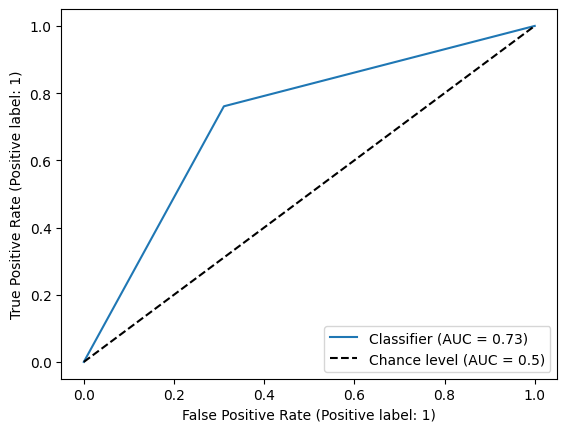

In [37]:
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True)
# roc_display.figure_.savefig("decision_base_roc_curve.png")
# Image("decision_base_roc_curve.png")

## RandomForest

In [42]:
random_forest_base = RandomForestClassifier(random_state=42)
random_forest_base.fit(train_X, train_y)
pred_y = random_forest_base.predict(test_X)

C:\Users\gonch\miniconda3\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [43]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,2861,548
True positive,1079,2947


In [44]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base random forest: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base random forest: precision=0.84, recall=0.73, f1=0.78


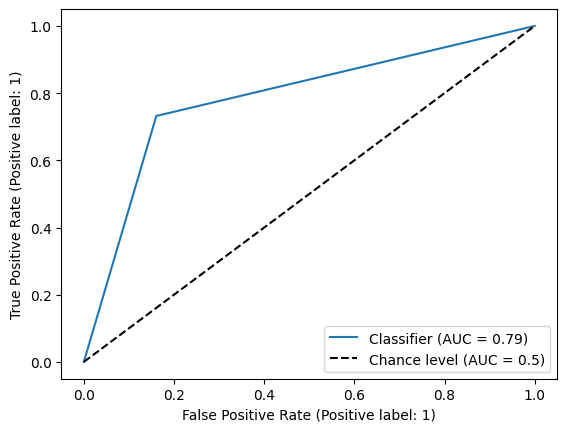

In [45]:
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True)

## SVM

In [49]:
svc_base = SVC(random_state=42)
svc_base.fit(train_X, train_y)
pred_y = svc_base.predict(test_X)

C:\Users\gonch\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,3000,409
True positive,1662,2364


In [51]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base SVC: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base SVC: precision=0.85, recall=0.59, f1=0.7


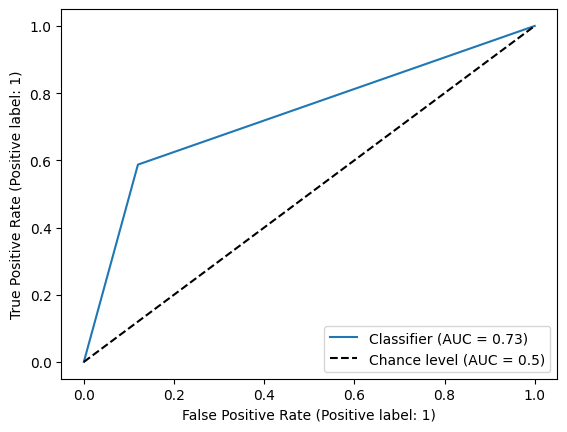

In [52]:
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True)

# Model selection
As we see in EDA, False negative costs more than False positive, therefore Recall socre should be high.  
According to above base model case, decision tree shows the highest recall score.  
I'll tune decision tree model to get the best score.  